In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from skimage.io import imread
from cellpose import plot, utils, io
from skimage.morphology import dilation, square
from skimage.measure import regionprops
from scipy.ndimage import binary_dilation
from Hexagonality_score import hexagonality_score

In [ ]:
FILEPATH = r"Copy_the_File_Path"
DATANAME = 'Copy_the_file_name'

data = np.load(os.path.join(FILEPATH, DATANAME + '_seg.npy'), allow_pickle=True).item() # It takes the file name and add the file extension at the end.
  
all_mask=copy.copy(data['masks'])
new_masks = utils.remove_edge_masks(data['masks'], change_index=True) # It removes the cell in the edge.

plt.imsave("all_mask.png", all_mask, cmap='gray') # mask is an image for each segment in the image assigned numbers from 0 to 255
plt.imsave("new_mask.png", new_masks, cmap='gray')
plt.close()

In [ ]:
mask = imread(r"c:\Users\kgenc\AppData\Local\Programs\Microsoft VS Code\new_mask.png")
mask = mask[:, :, 0].astype(float)

In [ ]:
# Initialize data dictionary
num_regions = int(all_mask.max())

data = {
    'centroid': np.full((num_regions, 2), np.nan),
    'neighbor_counts': np.full(num_regions, np.nan),
    'neighbor' : np.full(num_regions, np.nan),
    'area': np.full(num_regions, np.nan),
    'perimeter': np.full(num_regions, np.nan),
    'polyAve': np.full(num_regions, np.nan),
    'hexAve': np.full(num_regions, np.nan),
    'hexSd': np.full(num_regions, np.nan),
    'circularity' : np.full(num_regions, np.nan),
    'aspect_ratio' : np.full(num_regions, np.nan)
}

In [ ]:
image_height, image_width = all_mask.shape

In [ ]:
# Iterate through each ROI
# Either all_mask (with edges) or new_mask can be used for the analysis
for i in range(1, num_regions + 1):

    roi_positions = np.column_stack(np.where(all_mask == i))

    if 0 not in roi_positions or np.any(roi_positions[:, 0] != image_height) or np.any(roi_positions[:, 1] != image_width):

        region_mask = (all_mask == i)

        # Dilate the mask to find neighbors
        se = np.ones((3, 3))
        dilated_mask = binary_dilation(region_mask, structure=se)

        # Get neighboring region labels
        neighbors = np.unique(all_mask[dilated_mask & ~region_mask])
        
        # If fewer than 40 zeros (indicating border regions), process region
        #if np.sum(mask[dilated_mask & ~region_mask] == 0) < 40:
        neighbor_counts = len(neighbors[neighbors > 0])    

        # Get region properties using skimage regionprops
        props = regionprops(region_mask.astype(int))

        if len(props) > 0:
            props = props[0]

            # Assuming hexagonality_score is a function you have in Python
            dataHex = hexagonality_score(neighbor_counts, props)

            # Save data
            data['centroid'][i - 1, :] = props.centroid
            data['neighbor_counts'][i - 1] = neighbor_counts
            data['aspect_ratio'][i - 1] = dataHex['aspect_ratio']
            data['circularity'][i - 1] = dataHex['circularity_score']
            data['area'][i - 1] = props.area
            data['perimeter'][i - 1] = props.perimeter
            data['polyAve'][i - 1] = dataHex['polyAve']
            data['hexAve'][i - 1] = dataHex['hexAve']
            data['hexSd'][i - 1] = dataHex['hexSd']


In [ ]:
# Initialize Region dictionary with 2D arrays for each property, using the same shape as mask
Region = {
    'Area': np.zeros_like(all_mask, dtype=float),
    'Perimeter': np.zeros_like(all_mask, dtype=float),
    'Neighbor': np.zeros_like(all_mask, dtype=float),
    'HexAve': np.zeros_like(all_mask, dtype=float),
    'HexSt': np.zeros_like(all_mask, dtype=float),
    'PolyAve': np.zeros_like(all_mask, dtype=float),
    'Aspect_Ratio': np.zeros_like(all_mask, dtype=float),
    'Circularity': np.zeros_like(all_mask, dtype=float)
}

# Map each property value to its corresponding pixels in the 2D mask
for region_id in range(1, num_regions + 1):
    region_pixels = (all_mask == region_id)  # Mask pixels corresponding to the current region
    
    # Assign each property to the appropriate region in the Region matrices
    Region['Area'][region_pixels] = data['area'][region_id - 1] *0.006769 #convert pixels to um2
    Region['Perimeter'][region_pixels] = data['perimeter'][region_id - 1]
    Region['Neighbor'][region_pixels] = data['neighbor_counts'][region_id - 1]
    Region['HexAve'][region_pixels] = data['hexAve'][region_id - 1]
    Region['HexSt'][region_pixels] = data['hexSd'][region_id - 1]
    Region['PolyAve'][region_pixels] = data['polyAve'][region_id - 1]
    Region['Aspect_Ratio'][region_pixels] = data['aspect_ratio'][region_id - 1]
    Region['Circularity'][region_pixels] = data['circularity'][region_id - 1]


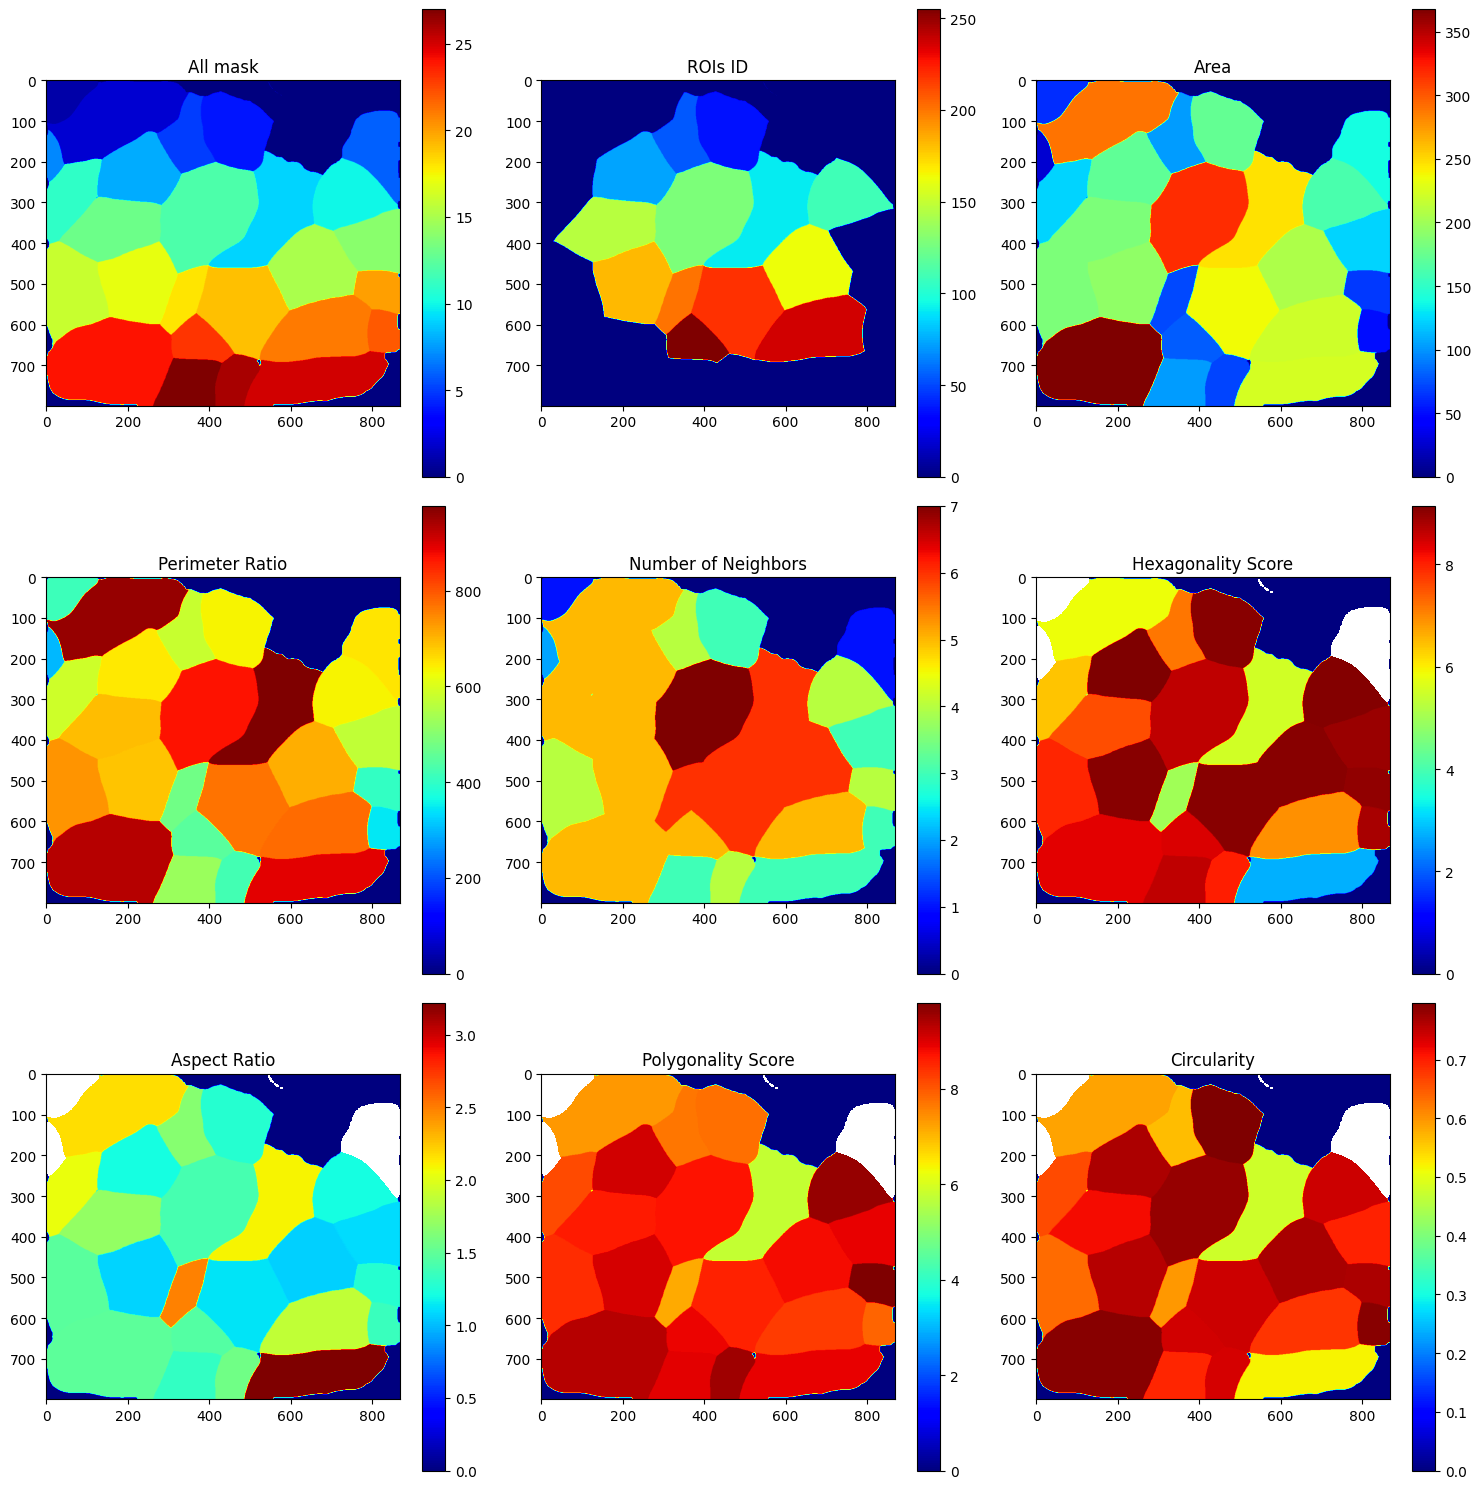

In [ ]:
# Plot everything
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Subplots with individual colorbars

im0 = axes[0, 0].imshow(all_mask, cmap='jet')
axes[0, 0].set_title('All mask')
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(mask, cmap='jet')
axes[0, 1].set_title('ROIs ID')
fig.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(Region['Area'], cmap='jet')
axes[0, 2].set_title('Area')
fig.colorbar(im2, ax=axes[0, 2])

im3 = axes[1, 0].imshow(Region['Perimeter'], cmap='jet')
axes[1, 0].set_title('Perimeter Ratio')
fig.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(Region['Neighbor'], cmap='jet')
axes[1, 1].set_title('Number of Neighbors')
fig.colorbar(im4, ax=axes[1, 1])

im5 = axes[1, 2].imshow(Region['HexAve'], cmap='jet')
axes[1, 2].set_title('Hexagonality Score')
fig.colorbar(im5, ax=axes[1, 2])

im6 = axes[2, 0].imshow(Region['Aspect_Ratio'], cmap='jet')
axes[2, 0].set_title('Aspect Ratio')
fig.colorbar(im6, ax=axes[2, 0])

im7 = axes[2, 1].imshow(Region['PolyAve'], cmap='jet')
axes[2, 1].set_title('Polygonality Score')
fig.colorbar(im7, ax=axes[2, 1])

im8 = axes[2, 2].imshow(Region['Circularity'], cmap='jet')
axes[2, 2].set_title('Circularity')
fig.colorbar(im8, ax=axes[2, 2])


# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Example data (assuming all arrays are 1D and of the same length)
data_dict = {
    "Number of neighbors" : data['neighbor_counts'],
    "Area": data['area'],
    "Perimeter": data['perimeter'],
    "Aspect_Ratio": data['aspect_ratio'],
    "HexAve": data['hexAve'],
    "HexSd": data['hexSd'],
    "PolyAve": data['polyAve']
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data_dict)

# Save the DataFrame to an Excel file
# Get rid of the NaN
df_cleaned = df.dropna() 

file_path = r"\\fshomes\kgenc$\Dokumente\RPE-J cellpose\Result.xlsx"

# Save the DataFrame as an Excel file
df_cleaned.to_excel(file_path, index=False, engine="openpyxl")

print(f"Data saved successfully at {file_path}")

Data saved successfully at \\fshomes\kgenc$\Dokumente\RPE-J cellpose\Result.xlsx
